In [1]:
from All_functions_simulation_univariate import * 
import math

In [2]:
def generate_points_on_sphere(n):
    phi = np.random.uniform(0, 2*np.pi, size=n)
    cos_theta = np.random.uniform(-1, 1, size=n)
    theta = np.arccos(cos_theta)

    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    return np.stack((x, y, z), axis=-1)

In [3]:
# Solve optimization problem in Liang's paper
def sdpDual(K, Y):
    n = Y.shape[0]
    y = Y[:,0]
    hB = cp.Variable((n, n), symmetric=True)
    constraints = [hB >> 0]
    constraints += [K[i, :] @ hB @ K[i, :] >= cp.square(y[i]) for i in range(n)]
    prob = cp.Problem(cp.Minimize(cp.trace(K @ hB)), constraints)
    prob.solve()
    return hB.value

The adjustment level delta is -0.5


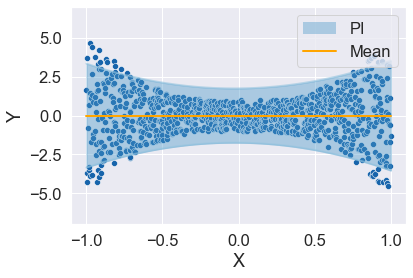

The overall coverage is 0.951
The mean bandwidth for testing data is 5.588078404540982


In [9]:
################################### UNIVARIATE SETUP 1 ###################################

# Generate i.i.d data
np.random.seed(5)
n_pre = 1000
n_opt = 100
n_adj = 100
n_t = 1000
n = n_pre+n_opt+n_adj+n_t

X = np.random.uniform(-1, 1, n).reshape(-1, 1)
Y = np.sqrt(1+25*np.power(X, 4))  * np.random.uniform(-1, 1, n).reshape(-1, 1)

# X_opt = X[0:n_pre+n_opt,:].reshape(-1, 1)
# Y_opt = Y[0:n_pre+n_opt,:].reshape(-1, 1)

X_pre = X[0:n_pre,:].reshape(-1, 1)
Y_pre = Y[0:n_pre,:].reshape(-1, 1)

X_opt = X[n_pre:n_pre+n_opt,:].reshape(-1, 1)
Y_opt = Y[n_pre:n_pre+n_opt,:].reshape(-1, 1)

X_adj = X[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)
Y_adj = Y[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)


X_t = X[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
Y_t = Y[n_pre+n_opt+n_adj:,:].reshape(-1, 1)

# Liang's method with polynomial kernel


known_mean = "True"
if known_mean == "True":
    M_pre = np.zeros(n_pre).reshape(-1,1)
    M_opt = np.zeros(n_opt).reshape(-1,1)
    M_adj = np.zeros(n_adj).reshape(-1,1)
    M_t = np.zeros(n_t).reshape(-1,1)
else:
    est_type = "NN2"
    M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)


degree = 2
X_inner_prod = X_opt @ X_opt.T
K = np.power(1 + X_inner_prod, degree)
output = sdpDual(K, Y_opt-M_opt)

# learn delta
K_adj = np.power(X_adj @ X_opt.T+1,degree)
shape_adj = K_adj @ output @ K_adj.T
shape_adj = shape_adj.diagonal()
K_t = np.power(X_t @ X_opt.T+1,degree)
shape_t = K_t @ output @ K_t.T
shape_t = shape_t.diagonal()

alpha = 0.05
delta = -1
Delta = 0
prop = 0.5
prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()
while prop_outside > (0.75 * alpha) and delta != Delta:
    delta = prop * delta + (1 - prop) * Delta
    prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()
    
print("The adjustment level delta is", delta)


V_alpha_t = (1 + delta) * shape_t
V_alpha_t = V_alpha_t.reshape(-1,1)
my_plot(X_t,Y_t,M_t,V_alpha_t,[-7,7])

The adjustment level delta is -0.125


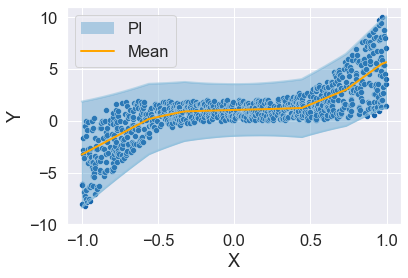

The overall coverage is 0.992
The mean bandwidth for testing data is 11.321437785621914


In [10]:
################################### UNIVARIATE SETUP 2 ###################################

np.random.seed(0)
n_pre = 1000
n_opt = 100
n_adj = 100
n_t = 1000
n = n_pre+n_opt+n_adj+n_t

X = np.random.uniform(-1, 1, n).reshape(-1, 1)
Y = 1+5*np.power(X, 3)+np.sqrt(1+25*np.power(X, 4))  * np.random.uniform(-1, 1, n).reshape(-1, 1)

X_pre = X[0:n_pre,:].reshape(-1, 1)
Y_pre = Y[0:n_pre,:].reshape(-1, 1)

X_opt = X[n_pre:n_pre+n_opt,:].reshape(-1, 1)
Y_opt = Y[n_pre:n_pre+n_opt,:].reshape(-1, 1)

X_adj = X[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)
Y_adj = Y[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)


X_t = X[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
Y_t = Y[n_pre+n_opt+n_adj:,:].reshape(-1, 1)

# Liang's method with polynomial kernel
known_mean = "False"
if known_mean == "True":
    M_pre = np.zeros(n_pre).reshape(-1,1)
    M_opt = np.zeros(n_opt).reshape(-1,1)
    M_adj = np.zeros(n_adj).reshape(-1,1)
    M_t = np.zeros(n_t).reshape(-1,1)
else:
    est_type = "NN2"
    M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)


degree = 2
X_inner_prod = X_opt @ X_opt.T
K = np.power(1 + X_inner_prod, degree)
output = sdpDual(K, Y_opt-M_opt)

# learn delta
K_adj = np.power(X_adj @ X_opt.T+1,degree)
shape_adj = K_adj @ output @ K_adj.T
shape_adj = shape_adj.diagonal()
K_t = np.power(X_t @ X_opt.T+1,degree)
shape_t = K_t @ output @ K_t.T
shape_t = shape_t.diagonal()

alpha = 0.05
delta = -1
Delta = 0
prop = 0.5
prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()
while prop_outside > (0.75 * alpha) and delta != Delta:
    delta = prop * delta + (1 - prop) * Delta
    prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()
    
print("The adjustment level delta is", delta)


V_alpha_t = (1 + delta) * shape_t
V_alpha_t = V_alpha_t.reshape(-1,1)
my_plot(X_t,Y_t,M_t,V_alpha_t,[-10,11],legend_loc = 'upper left')

The adjustment level delta is 0.5


/Users/jiawei/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


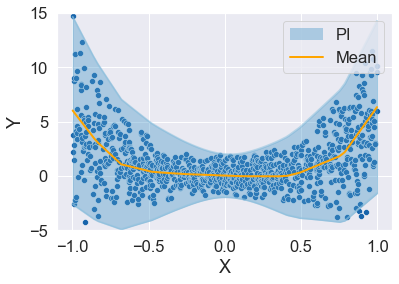

The overall coverage is 0.995
The mean bandwidth for testing data is 24.924264776052155


In [11]:
################################### UNIVARIATE SETUP 3 ###################################

np.random.seed(1)
n_pre = 1000
n_opt = 100
n_adj = 100
n_t = 1000
n = n_pre+n_opt+n_adj+n_t

# X = np.random.uniform(-1, 1, n).reshape(-1, 1)
# Y = np.random.laplace(1+5*np.power(X, 3),np.sqrt(1+25*np.power(X, 4)) )
# Y = np.median(np.hstack([np.power(X, 2)+np.power(X, 4)+6,np.power(X, 2)+np.power(X, 4)-6,Y]),axis=1).reshape(-1, 1)

X = np.random.uniform(-1, 1, n).reshape(-1, 1)

# Specify the mean and standard deviation for Y
mean_Y = np.power(X, 2)+5*np.power(X, 4)
std_dev_Y = np.sqrt(1 + 25 * np.power(X, 4))

# Specify the bounds for Y
lower_bound = mean_Y - 2 * std_dev_Y
upper_bound = mean_Y + 2 * std_dev_Y

# Generate all Y values initially
Y = np.random.laplace(mean_Y, std_dev_Y)

# Correct values that fall out of bounds
while True:
    out_of_bounds = (Y < lower_bound) | (Y > upper_bound)
    if not np.any(out_of_bounds):
        break
    Y[out_of_bounds] = np.random.laplace(mean_Y[out_of_bounds], std_dev_Y[out_of_bounds])
    
X_pre = X[0:n_pre,:].reshape(-1, 1)
Y_pre = Y[0:n_pre,:].reshape(-1, 1)


X_opt = X[n_pre:n_pre+n_opt,:].reshape(-1, 1)
Y_opt = Y[n_pre:n_pre+n_opt,:].reshape(-1, 1)

X_adj = X[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)
Y_adj = Y[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)


X_t = X[n_pre+n_opt+n_adj:,:].reshape(-1, 1)
Y_t = Y[n_pre+n_opt+n_adj:,:].reshape(-1, 1)

# Liang's method with polynomial kernel
known_mean = "False"
if known_mean == "True":
    M_pre = np.zeros(n_pre).reshape(-1,1)
    M_opt = np.zeros(n_opt).reshape(-1,1)
    M_adj = np.zeros(n_adj).reshape(-1,1)
    M_t = np.zeros(n_t).reshape(-1,1)
else:
    est_type = "NN2"
    M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)


degree = 2
X_inner_prod = X_opt @ X_opt.T
K = np.power(1 + X_inner_prod, degree)
output = sdpDual(K, Y_opt-M_opt)

# learn delta
K_adj = np.power(X_adj @ X_opt.T+1,degree)
shape_adj = K_adj @ output @ K_adj.T
shape_adj = shape_adj.diagonal()
K_t = np.power(X_t @ X_opt.T+1,degree)
shape_t = K_t @ output @ K_t.T
shape_t = shape_t.diagonal()

alpha = 0.05
delta = -1
Delta = 1
prop = 0.5
prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()
while prop_outside > (0.75 * alpha) and delta != Delta:
    delta = prop * delta + (1 - prop) * Delta
    prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()
    
print("The adjustment level delta is", delta)


V_alpha_t = (1 + delta) * shape_t
V_alpha_t = V_alpha_t.reshape(-1,1)
my_plot(X_t,Y_t,M_t,V_alpha_t,[-5,15])

In [ ]:
################################### MULTIVARIATE SETUP 1 ###################################
np.random.seed(5)
n_pre = 1000
n_opt = 900
n_adj = 100
n_t = 1000
n = n_pre+n_opt+n_adj+n_t
beta = np.array([1/math.sqrt(3),1/math.sqrt(3),-1/math.sqrt(3)])

X = generate_points_on_sphere(n)
Y = np.sqrt(1+25*np.power(X @ beta, 4))  * np.random.uniform(-1, 1, n)
Y = Y.reshape(-1,1)

X_pre = X[0:n_pre,:]
Y_pre = Y[0:n_pre,:].reshape(-1, 1)

X_opt = X[n_pre:n_pre+n_opt,:]
Y_opt = Y[n_pre:n_pre+n_opt,:].reshape(-1, 1)

X_adj = X[n_pre+n_opt:n_pre+n_opt+n_adj,:]
Y_adj = Y[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)


X_t = X[n_pre+n_opt+n_adj:,:]
Y_t = Y[n_pre+n_opt+n_adj:,:].reshape(-1, 1)


# Liang's method with polynomial kernel
known_mean = "True"
if known_mean == "True":
    M_pre = np.zeros(n_pre).reshape(-1,1)
    M_opt = np.zeros(n_opt).reshape(-1,1)
    M_adj = np.zeros(n_adj).reshape(-1,1)
    M_t = np.zeros(n_t).reshape(-1,1)
else:
    est_type = "NN2"
    M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)


degree = 2
X_inner_prod = X_opt @ X_opt.T
K = np.power(1 + X_inner_prod, degree)
output = sdpDual(K, Y_opt-M_opt)

# learn delta
K_adj = np.power(X_adj @ X_opt.T+1,degree)
shape_adj = K_adj @ output @ K_adj.T
shape_adj = shape_adj.diagonal()
K_t = np.power(X_t @ X_opt.T+1,degree)
shape_t = K_t @ output @ K_t.T
shape_t = shape_t.diagonal()

alpha = 0.05
delta = -1
Delta = 0
prop = 0.5
prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()
while prop_outside > (0.75 * alpha) and delta != Delta:
    delta = prop * delta + (1 - prop) * Delta
    prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()
    
print("The adjustment level delta is", delta)


V_alpha_t = (1 + delta) * shape_t
V_alpha_t = V_alpha_t.reshape(-1,1)
coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_alpha_t[:,0]).mean()
bandwidth = np.mean(V_alpha_t[:,0])
print("The overall coverage is", coverage)
print("The mean bandwidth for testing data is", bandwidth)

In [ ]:
################################### MULTIVARIATE SETUP 2 ###################################
np.random.seed(0)
n_pre = 1000
n_opt = 900
n_adj = 100
n_t = 1000
n = n_pre+n_opt+n_adj+n_t
beta = np.array([1/math.sqrt(3),1/math.sqrt(3),-1/math.sqrt(3)])

X = generate_points_on_sphere(n)
Y = 1+5*np.power(X @ beta, 3)+np.sqrt(1+25*np.power(X @ beta, 4))  * np.random.uniform(-1, 1, n)
Y = Y.reshape(-1,1)

X_pre = X[0:n_pre,:]
Y_pre = Y[0:n_pre,:].reshape(-1, 1)

X_opt = X[n_pre:n_pre+n_opt,:]
Y_opt = Y[n_pre:n_pre+n_opt,:].reshape(-1, 1)

X_adj = X[n_pre+n_opt:n_pre+n_opt+n_adj,:]
Y_adj = Y[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)


X_t = X[n_pre+n_opt+n_adj:,:]
Y_t = Y[n_pre+n_opt+n_adj:,:].reshape(-1, 1)

# Liang's method with polynomial kernel
known_mean = "False"
if known_mean == "True":
    M_pre = np.zeros(n_pre).reshape(-1,1)
    M_opt = np.zeros(n_opt).reshape(-1,1)
    M_adj = np.zeros(n_adj).reshape(-1,1)
    M_t = np.zeros(n_t).reshape(-1,1)
else:
    est_type = "NN2"
    M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)


degree = 2
X_inner_prod = X_opt @ X_opt.T
K = np.power(1 + X_inner_prod, degree)
output = sdpDual(K, Y_opt-M_opt)

# learn delta
K_adj = np.power(X_adj @ X_opt.T+1,degree)
shape_adj = K_adj @ output @ K_adj.T
shape_adj = shape_adj.diagonal()
K_t = np.power(X_t @ X_opt.T+1,degree)
shape_t = K_t @ output @ K_t.T
shape_t = shape_t.diagonal()

alpha = 0.05
delta = -1
Delta = 0
prop = 0.5
prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()
while prop_outside > (0.75 * alpha) and delta != Delta:
    delta = prop * delta + (1 - prop) * Delta
    prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()
    
print("The adjustment level delta is", delta)


V_alpha_t = (1 + delta) * shape_t
V_alpha_t = V_alpha_t.reshape(-1,1)
coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_alpha_t[:,0]).mean()
bandwidth = np.mean(V_alpha_t[:,0])
print("The overall coverage is", coverage)
print("The mean bandwidth for testing data is", bandwidth)

In [ ]:
################################### MULTIVARIATE SETUP 3 ###################################
np.random.seed(1)
n_pre = 1000
n_opt = 900
n_adj = 100
n_t = 1000
n = n_pre+n_opt+n_adj+n_t
beta = np.array([1/math.sqrt(3),1/math.sqrt(3),-1/math.sqrt(3)])

X = generate_points_on_sphere(n)

# Specify the mean and standard deviation for Y
mean_Y = np.power(X @ beta, 2)+5*np.power(X @ beta, 4)
std_dev_Y = np.sqrt(1 + 25 * np.power(X @ beta, 4))
mean_Y = mean_Y.reshape(-1,1)
std_dev_Y  = std_dev_Y .reshape(-1,1)

# Specify the bounds for Y
lower_bound = mean_Y - 2 * std_dev_Y
upper_bound = mean_Y + 2 * std_dev_Y

# Generate all Y values initially
Y = np.random.laplace(mean_Y, std_dev_Y)

# Correct values that fall out of bounds
while True:
    out_of_bounds = (Y < lower_bound) | (Y > upper_bound)
    if not np.any(out_of_bounds):
        break
    Y[out_of_bounds] = np.random.laplace(mean_Y[out_of_bounds], std_dev_Y[out_of_bounds])


X_pre = X[0:n_pre,:]
Y_pre = Y[0:n_pre,:].reshape(-1, 1)

X_opt = X[n_pre:n_pre+n_opt,:]
Y_opt = Y[n_pre:n_pre+n_opt,:].reshape(-1, 1)

X_adj = X[n_pre+n_opt:n_pre+n_opt+n_adj,:]
Y_adj = Y[n_pre+n_opt:n_pre+n_opt+n_adj,:].reshape(-1, 1)


X_t = X[n_pre+n_opt+n_adj:,:]
Y_t = Y[n_pre+n_opt+n_adj:,:].reshape(-1, 1)

# Liang's method with polynomial kernel
known_mean = "False"
if known_mean == "True":
    M_pre = np.zeros(n_pre).reshape(-1,1)
    M_opt = np.zeros(n_opt).reshape(-1,1)
    M_adj = np.zeros(n_adj).reshape(-1,1)
    M_t = np.zeros(n_t).reshape(-1,1)
else:
    est_type = "NN2"
    M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)


degree = 2
X_inner_prod = X_opt @ X_opt.T
K = np.power(1 + X_inner_prod, degree)
output = sdpDual(K, Y_opt-M_opt)

# learn delta
K_adj = np.power(X_adj @ X_opt.T+1,degree)
shape_adj = K_adj @ output @ K_adj.T
shape_adj = shape_adj.diagonal()
K_t = np.power(X_t @ X_opt.T+1,degree)
shape_t = K_t @ output @ K_t.T
shape_t = shape_t.diagonal()

alpha = 0.05
delta = -1
Delta = 0
prop = 0.5
prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()
while prop_outside > (0.75 * alpha) and delta != Delta:
    delta = prop * delta + (1 - prop) * Delta
    prop_outside = (np.power(Y_adj-M_adj, 2)[:,0] > (1 + delta) * shape_adj).mean()
    
print("The adjustment level delta is", delta)


V_alpha_t = (1 + delta) * shape_t
V_alpha_t = V_alpha_t.reshape(-1,1)
coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_alpha_t[:,0]).mean()
bandwidth = np.mean(V_alpha_t[:,0])
print("The overall coverage is", coverage)
print("The mean bandwidth for testing data is", bandwidth)